In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
np.random.seed(123)
import seaborn as sns
import matplotlib.pyplot as plt

import shap
print(f"Shap version used: {shap.__version__}")
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor

Shap version used: 0.41.0


In [4]:
# We will read the training data
data = pd.read_csv('winequality-red.csv')
data.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [6]:
data.shape

(1599, 12)

In [7]:
data.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [9]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Now that we see that our dataset has 10 features with all float values, we do not need to do any encoding of features. We can do data normalization for getting more accurate models. But our focus is on the model interpretability part using SHAP. So, we will skip the EDA and normalization part and build a simple ML model which might not be very accurate using the Random Forest algorithm. We still need to check for missing values, as a dataset with missing values can cause problems later.

In [10]:
# Dropping missing values
data.fillna(0,inplace=True)
data.shape

(1599, 12)

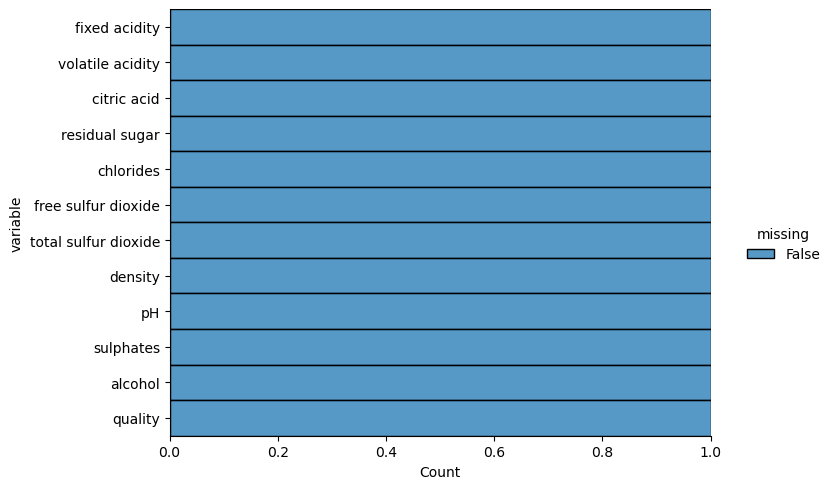

In [19]:
# Handling missing values
sns.displot(
    data=data.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.5
)
plt.show()

No missing values found in the data. We can proceed with the model training process.

# Training the model

In [20]:
data["quality"].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [21]:
features = data.drop(columns=['quality'])
labels = data['quality']
# Dividing the data into training-test set with 80:20 split ratio
x_train,x_test,y_train,y_test = train_test_split(features,labels,test_size=0.2, random_state=123)

In [27]:
model = RandomForestRegressor(n_estimators=2000, max_depth=30, random_state=123)
model.fit(x_train, y_train)

RandomForestRegressor(max_depth=30, n_estimators=2000, random_state=123)

In [28]:
model.score(x_test, y_test)

0.49976030471036337

The coefficient of determination ( coefficient) is around 0.5. The scores indicate that we do not have a very good ML model. Hence, it is even more important to explain such models. Let's define the prediction probability function (f) now, which we will used by the SHAP framework.

# Using SHAP for model interpretability

In [29]:
explainer = shap.Explainer(model)
shap_values = explainer(x_test)

# Model interpretability using SHAP visualizations

SHAP provides many visualization options to explain the working of the model

## Global interpretability with feature importance

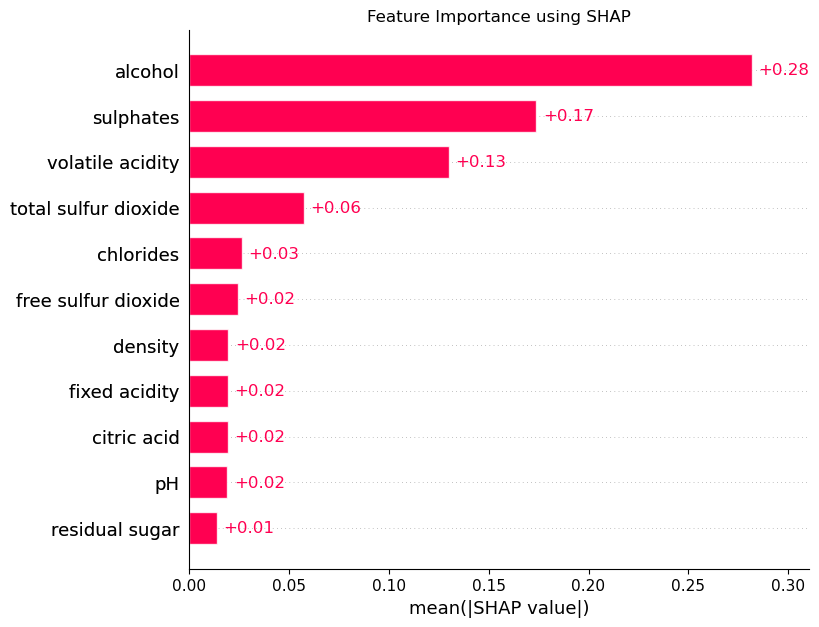

In [30]:
plt.title('Feature Importance using SHAP')
shap.plots.bar(shap_values, show=True, max_display=12)

Feature importance is one of the most common model explainability method. Instead of calculating feature importance in terms of learned model weighted, SHAP provides a model-agnostic approach to highlight the most influential features based on the mean absolute SHAP values.

1. Pro - Easy to interpret and very helpful to identify the dominating features based on the collective interactive with other features using SHAP values.
2. Con - Since it shows features based on mean absolute Shap values, it is hard to identify features which are positively influencing the model and negatively influencing the model.

## Global interpretability with heatmap plots

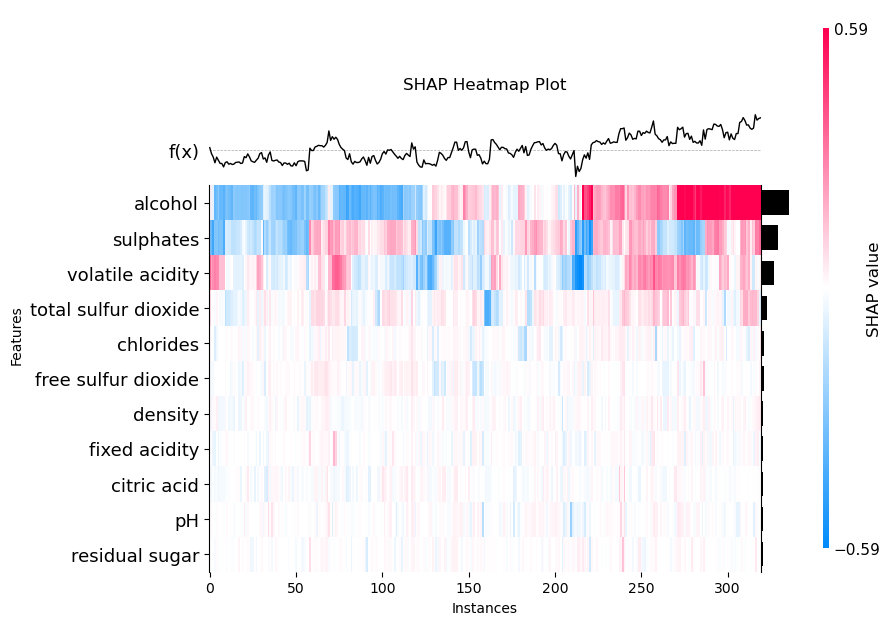

In [34]:
plt.title('SHAP Heatmap Plot')
shap.plots.heatmap(shap_values, max_display=12, show=False)
plt.gcf().axes[-1].set_box_aspect(100)
plt.ylabel('Features')
plt.show()

Heatmaps are essential to understand the overall impact of all features on the model. The heatmap shown above shows how the quality of the alcohol increases with higher amount of alcohol and sulphates as these features have higher shap values, indicated by the red region. The f(x) curve on the top, shows how the predicted value of wine quality increases with the increase in the number of data instances. This might be because the alcohol content and sulphate content is positively influencing the outcome.

1. Pro - Shows the most influential features and how the overall prediction varies with the data instances.
2. Con - Can be complicated to interpret for any common user.

##  Global interpretability with Cohort plots

In [35]:
# index of the feature alcohol is 10
f_idx = 10
alcohol = ["High Alcohol" if shap_values[i].data[f_idx] >=10.0 else "Low Alcohol" for i in range(shap_values.shape[0])]

In [42]:
print(shap_values[1].data[10])
print(shap_values[2].data[10])
print(shap_values[3].data[10])
print(shap_values[4].data[10])

9.4
9.2
12.3
9.3


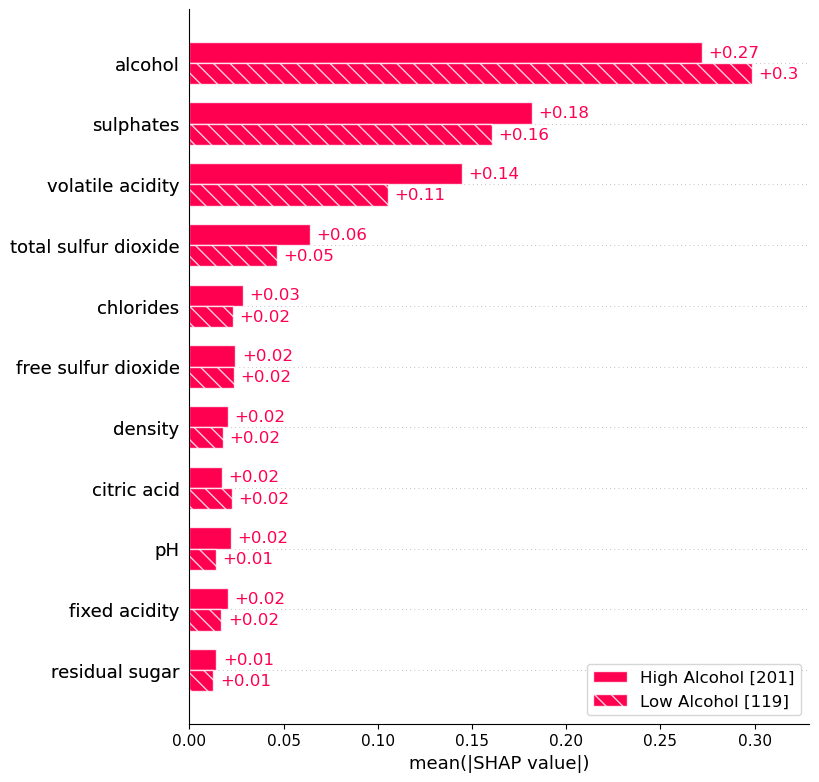

In [43]:
shap.plots.bar(shap_values.cohorts(alcohol).abs.mean(0), max_display=12)

SHAP provides a unique way of forming sub-groups or cohorts to analyze feature importance. The same pros and cons remain like SHAP bar plots.

## Global interpretability with feature clustering

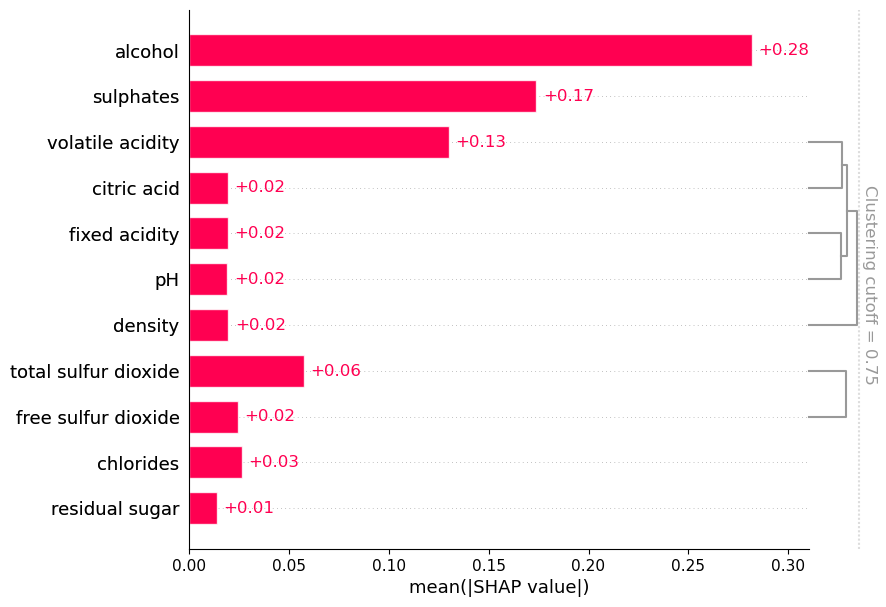

In [45]:
clustering = shap.utils.hclust(x_test, y_test)
shap.plots.bar(shap_values, clustering=clustering, clustering_cutoff=0.75, max_display = 12)

This is another interesting visualization from SHAP. The clustering features helps us to visualize grouped features or features which have high interaction with each other. As we can see from the visual that volatile acidity and citric acid forms a group and pH and fixed acidity form another group, but collectively these sub groups interact with the density and forms a hierarchical cluster. So, this method uses hierarchical clustering to find features which have high interaction with each other and influences the model in a collective approach.

## Global interpretability with SHAP summary plots

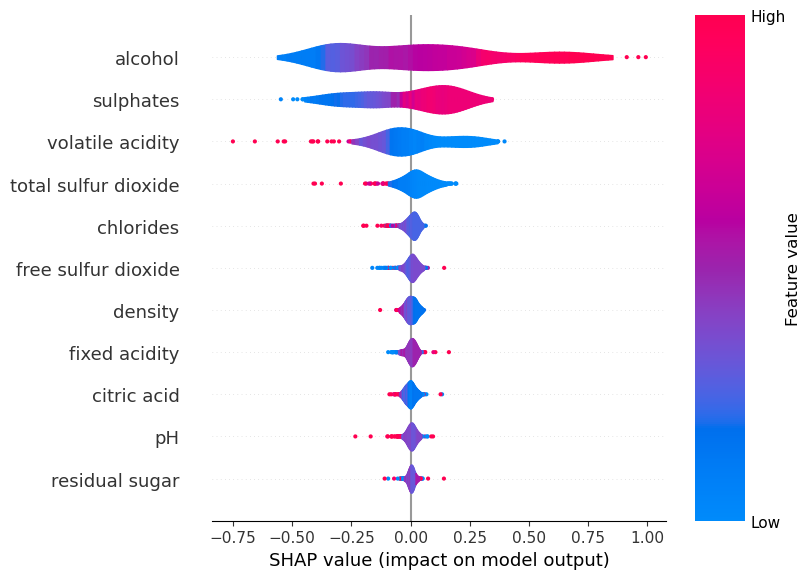

In [46]:
shap.summary_plot(shap_values, x_test, plot_type="violin", show=False)
plt.gcf().axes[-1].set_box_aspect(10)
plt.show()

SHAP Summary plots are interesting visualizations that does give alot of information and it is much better than feature importance bar plots. We can get the following information from SHAP summary plots.

1. Shapley value based feature importance - The plot shows the importance of the features in descending order of their importance based on Shapley values. The horizontal violin plot visualization shows the positive or the negative impact of the feature for some data points. But the impact of the feature values is displayed from high to low using interesting color combinations.
2. Feature correlation - The color of the horizontal violin plots for each feature shows the positive or negative correlation with the target outcome. From the plot, we can say that as alcohol is most depicted with the red color gradient, it has a positive correlation with the wine quality, whereas volatile acidity is depicted with blue color gradient, indicating that it has negative correlation with the target outcome, which is wine quality.

## Global interpretability with feature dependence plot

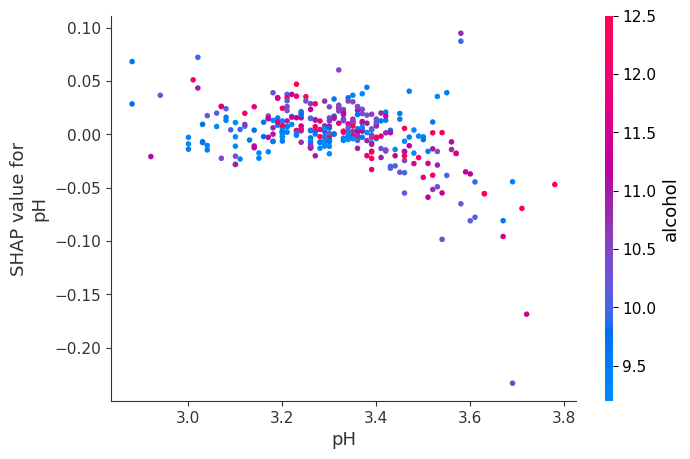

In [47]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test)
shap.dependence_plot("pH", shap_values, x_test, show=False)
plt.gcf().axes[-1].set_box_aspect(50)

The dependence plot helps us find out the partial dependence of a particular feature with another feature. From the visualization, we can interpret that for wines with higher alcohol content have slightly less pH values. This is an interesting plot to study interactions between the influential features

## Local interpretability using Waterfall plots

100%|===================| 319/320 [02:21<00:00]        

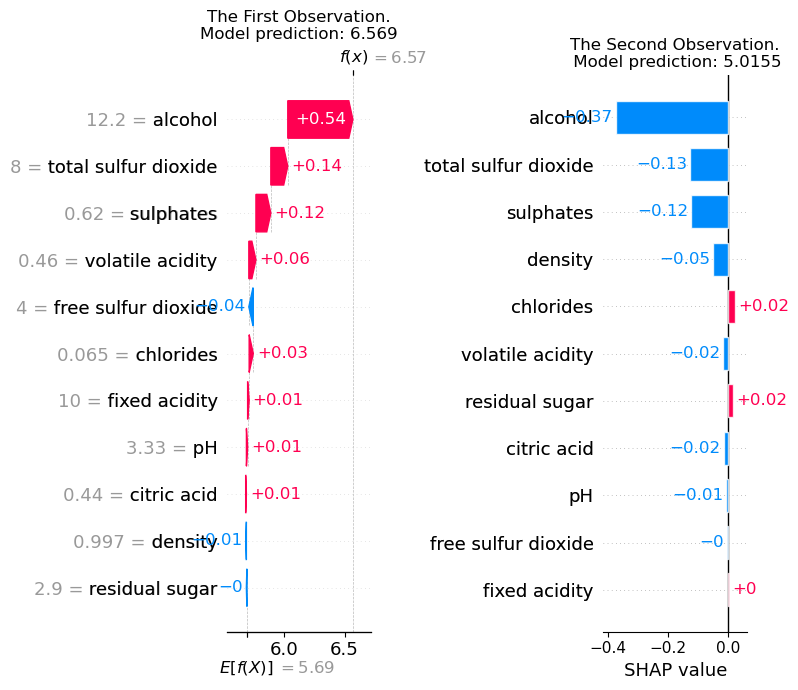

In [48]:
figure = plt.figure(figsize=(25,12))
ax1 = figure.add_subplot(121)

explainer = shap.Explainer(model, x_test)
shap_values = explainer(x_test)
# For the test observation with index 0
shap.plots.waterfall(shap_values[0], max_display = 12, show=False)
ax1.title.set_text(f'The First Observation.\nModel prediction: {model.predict(x_test)[0]}')

ax2 = figure.add_subplot(122)
# Similarly for the test observation with index 1
shap.plots.bar(shap_values[1], max_display = 12, show=False) 
ax2.title.set_text(f'The Second Observation.\n Model prediction: {model.predict(x_test)[1]}')
plt.tight_layout()
plt.show()

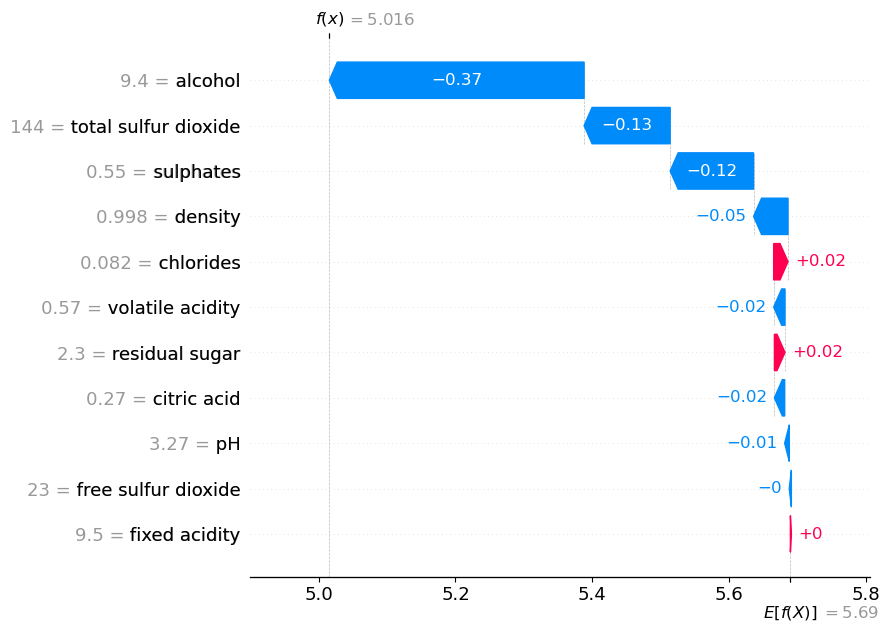

In [49]:
shap.plots.waterfall(shap_values[1], max_display = 12) 

The waterfall plot is another interesting local interpretability plot available in SHAP. It is better than Feature Importance plots as it shows how each feature value of the local inference data contributes positively or negatively towards the model prediction. As we can see from the plot, for the second test observation, the alcohol value is lower than the mean value and hence it has a negative shapley value. The negative shapley value indicates that although alcohol is the most influential feature in the dataset, but since for the current inference data instance, the value of alcohol is lower than the average value, it is negatively influencing the model to give a lower prediction value for the wine quality. But compared to a waterfall plots, SHAP barplots are centered at 0.

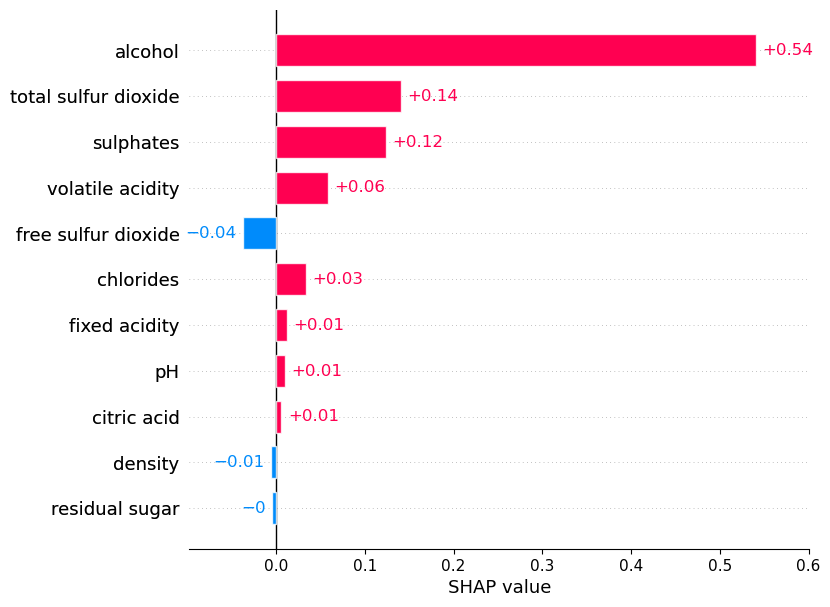

In [50]:
shap.plots.bar(shap_values[0], max_display = 12)

 99%|===================| 318/320 [02:23<00:00]        

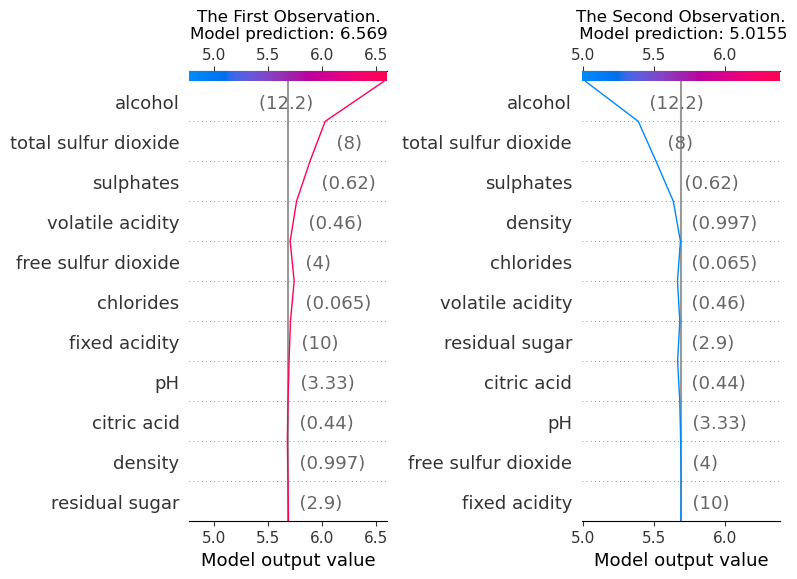

In [51]:
expected_value = explainer.expected_value
figure = plt.figure(figsize=(10,5))
ax1 = figure.add_subplot(121)
shap_values = explainer.shap_values(x_test)[0]
shap.decision_plot(expected_value, shap_values, x_test, show=False)
ax1.title.set_text(f'The First Observation.\nModel prediction: {model.predict(x_test)[0]}')

ax2 = figure.add_subplot(122)
shap_values = explainer.shap_values(x_test)[1]
shap.decision_plot(expected_value, shap_values, x_test, show=False)
ax2.title.set_text(f'The Second Observation.\n Model prediction: {model.predict(x_test)[1]}')
plt.tight_layout()
plt.show()

As observed previously, barplots and even waterfall plots do not show the mean values of all the features and the mean predicted outcome.That is when decision plots are more useful for local explanations. It shows where the current local prediction of the model is higher or lower than the average predicted outcome and the most influential features, and how value of such features in the local data instance is affecting towards the model outcome. In the two examples shown, in both the cases the features alcohol, total sulfur dioxide and sulphates are either positively impacting or negatively impacting the model, thus leading to a higher or lower model predicton respectively. Other features are not significantly impacting the model's decision.